**In this notebook I have train a CNN model. I have also show how to data pipelining and data augmentation work.**

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow_model_optimization as tfmot
import h5py
from keras.models import load_model
from tensorflow import keras
from sklearn.metrics import accuracy_score
import tempfile
import zipfile
import os
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

**Import data into tensorflow dataset object**

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Models/potato_leaf_diseases/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4627 files belonging to 5 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 0 0 1 1 0 3 0 2 1 0 3 2 2 2 1 0 1 0 2 0 3 2 3 0 0 2 1 0 1 3 3]


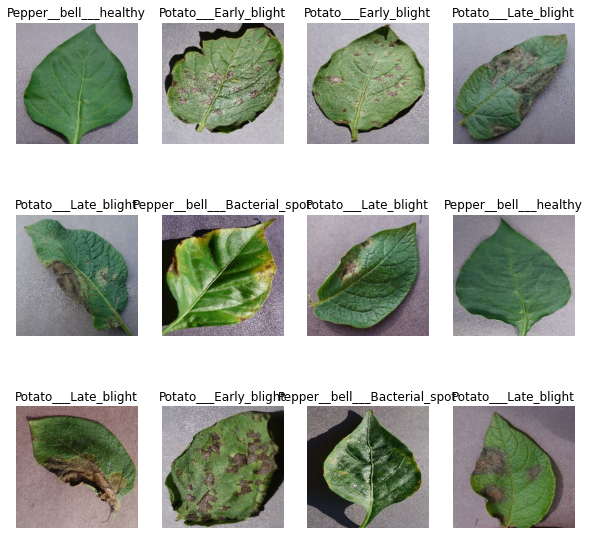

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

145

**Function to Split dataset into training, test and validation **

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

116

In [ ]:
len(val_ds)

14

In [ ]:
len(test_ds)

15

**Cache, Shuffle, and Prefetch the Dataset**

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

**Data augmentation**

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

**Model training**

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu', kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu', kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30)

Epoch 1/30
116/116 [==============================] - 839s 4s/step - loss: 2.1770 - accuracy: 0.3328 - val_loss: 1.5310 - val_accuracy: 0.3057
Epoch 2/30
116/116 [==============================] - 406s 3s/step - loss: 1.2108 - accuracy: 0.5550 - val_loss: 1.0446 - val_accuracy: 0.6253
Epoch 3/30
116/116 [==============================] - 403s 3s/step - loss: 0.9759 - accuracy: 0.6513 - val_loss: 0.8662 - val_accuracy: 0.6920
Epoch 4/30
116/116 [==============================] - 401s 3s/step - loss: 0.8452 - accuracy: 0.7124 - val_loss: 0.8520 - val_accuracy: 0.6759
Epoch 5/30
116/116 [==============================] - 404s 3s/step - loss: 0.7617 - accuracy: 0.7351 - val_loss: 0.7634 - val_accuracy: 0.6966
Epoch 6/30
116/116 [==============================] - 407s 4s/step - loss: 0.7166 - accuracy: 0.7589 - val_loss: 0.6987 - val_accuracy: 0.7609
Epoch 7/30
116/116 [==============================] - 406s 3s/step - loss: 0.6941 - accuracy: 0.7664 - val_loss: 0.6967 - val_accuracy: 0.7471

In [ ]:
scores = model.evaluate(test_ds)

15/15 [==============================] - 26s 787ms/step - loss: 0.4021 - accuracy: 0.9000


In [ ]:
scores

[0.40213871002197266, 0.8999999761581421]

**Testing the model**

first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


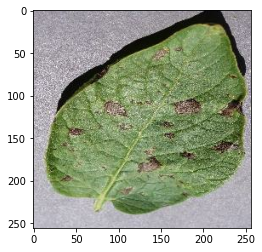

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

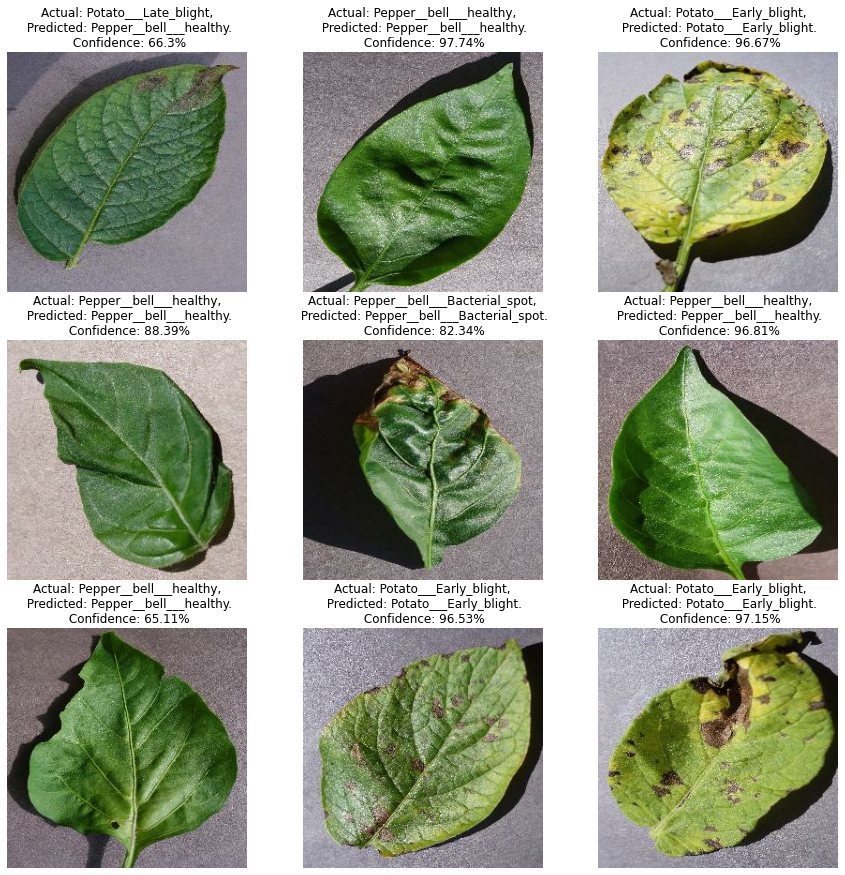

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

**Graph plotting**

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
len(acc)

30

In [ ]:
len(acc)

30

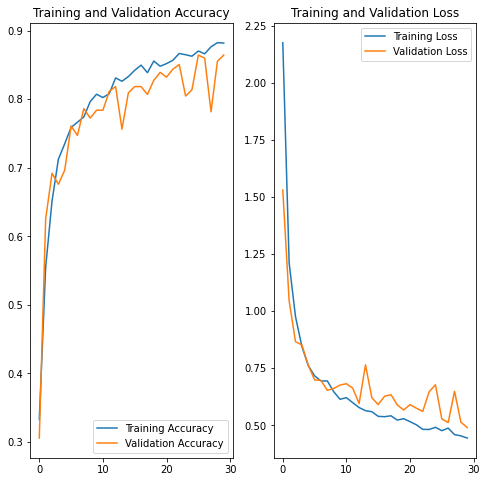

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Saving the model**

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/Models/potato_leaf_diseases/models") + [0]])+1
model.save(f"/content/drive/MyDrive/Models/potato_leaf_diseases/models/{model_version}")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/potato_leaf_diseases/models/1/assets


In [ ]:
model.save("/content/drive/MyDrive/Models/potato_leaf_diseases/models/potatoes.h5")